# Import

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
!pip install -q --upgrade tensorflow-probability

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print('TFP Version =%s'%(tfp.__version__))

TFP Version =0.9.0


In [4]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import seaborn as sns
import sys
import time
import contextlib
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Preprocessing

## Load

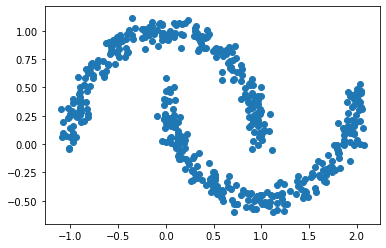

In [5]:
DATASET_SIZE = 1024 * 8
X,y = datasets.make_moons(n_samples=DATASET_SIZE, noise=.06, random_state=0)
plt.scatter(X[:500, 0], X[:500, 1])

## Pipeline

In [0]:
BATCH_SIZE = 256
SAMPLE_SIZE = DATASET_SIZE

moons_ds = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.shuffle(DATASET_SIZE, seed=0, reshuffle_each_iteration=True)
moons_ds = moons_ds.batch(BATCH_SIZE, drop_remainder=True)

# Model

## Base Distribution

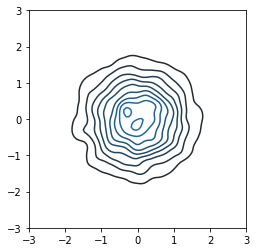

In [7]:
base_distribution = tfd.MultivariateNormalDiag(loc=0., scale_diag=[0.8, 0.8])
samples = base_distribution.sample(10000).numpy()

plt.axes(aspect='equal', xlim=(-3,3), ylim=(-3,3))
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

## MLP

In [0]:
NUM_HIDDEN_UNITS = 8
NUM_HIDDEN_LAYERS = 2
DIM_INPUTS = 2 # dim_output must be equal to dim_input in time_derivative_fn of ODE 

class MLP_ODE(tfk.Model):
  def __init__(self):
    super(MLP_ODE, self).__init__()
    self._layers = []
    for _ in range(NUM_HIDDEN_LAYERS):
      self._layers.append(tfkl.Dense(NUM_HIDDEN_UNITS, 'tanh'))
    self._layers.append(tfkl.Dense(DIM_INPUTS))
  
  def call(self, t, inputs):
    x = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    for l in self._layers: x = l(x)
    return x

## Bijector

In [0]:
STACKED_FFJORDS = 3
ATOL = 1e-3

solver = tfp.math.ode.DormandPrince(atol=ATOL)
trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson

bijectors = []
for _ in range(STACKED_FFJORDS):
  next_ffjord = tfb.FFJORD(
      state_time_derivative_fn=MLP_ODE(),
      ode_solve_fn=solver.solve,
      trace_augmentation_fn=trace_augmentation_fn)
  bijectors.append(next_ffjord)

# tfb.Chain takes a list of bijectors in the reverse order where they are applied
stacked_ffjord = tfb.Chain(bijectors[::-1])

In [0]:
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution,
    bijector=stacked_ffjord)

# Train

## Utils

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Optimization

In [12]:
@tf.function
def train_step(dist, optimizer, samples):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(dist.log_prob(samples)) # negative log likelihood (NLL)
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return loss


LR = 3e-3
NUM_EPOCHS = 100

optimizer = tfk.optimizers.Adam(LR)
losses = []

with measure_time(), overwriting_stdout():
  for epoch in range(NUM_EPOCHS):
    loss = 0.
    for n, X in enumerate(moons_ds):
      loss += train_step(transformed_distribution, optimizer, X).numpy()
    loss /= (n+1.)
    losses.append(loss)
    sys.stdout.write('Epoch {}: Loss = {}'.format(epoch+1,loss))

Epoch 100: Loss = 0.6361150406301022
Elapsed Time 1542.602068 [sec]


Text(0, 0.5, 'NLL')

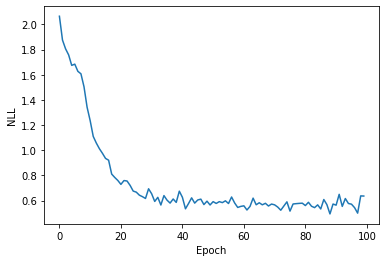

In [13]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')

# Results

## Scatter Plots

In [0]:
def get_samples(sample_size):
  base_distribution_samples = base_distribution.sample(sample_size)
  transformed_samples = transformed_distribution.sample(sample_size)
  return base_distribution_samples, transformed_samples

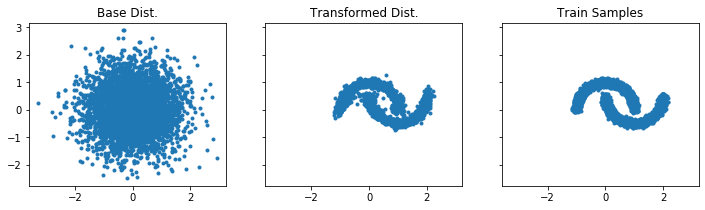

In [15]:
base_samps, trans_samps = get_samples(4000)
X = np.vstack(list(moons_ds.as_numpy_iterator()))

fig,axes = plt.subplots(1,3,figsize=[12,3],sharex=True,sharey=True)

for ax,x,ttl in zip(
    np.ravel(axes), 
    [base_samps, trans_samps, X],
    ['Base Dist.', 'Transformed Dist.', 'Train Samples']):
  
  ax.scatter(x[:,0],x[:,1],marker='.')
  ax.set_title(ttl)

## KDE Plot

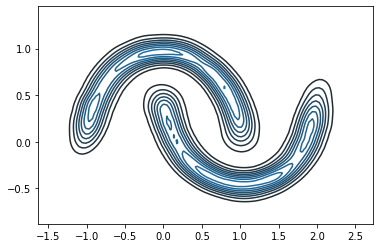

In [16]:
_, trans_samps = get_samples(40000)
trans_samps = trans_samps.numpy()
x, y = trans_samps[:,0], trans_samps[:,1]
sns.kdeplot(x,y)

# References

1. https://arxiv.org/abs/1806.07366
1. https://arxiv.org/abs/1810.01367
1. https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/FFJORD_Demo.ipynb